In [58]:
import requests
import json
import pandas as pd
import seaborn as sns
import sklearn.feature_extraction.text as text
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDRegressor
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.datasets import fetch_lfw_people
from sklearn.manifold import Isomap
import statsmodels.api as sm
import scipy as sc
from sklearn.metrics import r2_score
import re
import numpy as np
import gensim
import gensim.downloader as model_api
import matplotlib.pyplot as plt
from matplotlib import offsetbox
import umap

# 1. App Review NLP work

This question uses the Apple App review dataset that you generated in the "Pulling online data" workshop. Your dataset should have at least 3-5 different applications, with data from a few countries.

**1.1** Using the bag-of-words or TF-IDF vector model (from SKLearn), cluster the reviews into 5 clusters. Measure the accuracy of the cluster overlap against the real review scores.

In [6]:
apps = {"Facebook": 284882215}
reviews = []
ratings = []
versions = []
titles = []
votes = []

countries = ["au", "us", "ca", "uk", "nz", "gh", "ng", "fj", "sg", "ie", "ke", "gd", "za", "ag", "bs", "bb", "bz", "dm", "gy", 
            "jm", "lr", "pg", "kn", "lc", "vc", "sl", "tt"]

In [7]:
page = 1
next = False

for app in apps:
    
    for country in countries:
        next = False 
        while not next:
            try:
                r = requests.get(f"https://itunes.apple.com/{country}/rss/customerreviews/id={apps[app]}/page={page}/sortby=mostrecent/json")
                content = json.loads(r.content)

                for review in content["feed"]["entry"]:
                    
                    reviews.append(review["content"]["label"])
                    versions.append(review["im:version"]["label"])
                    ratings.append(review["im:rating"]["label"])
                    titles.append(review["title"]["label"])
                    votes.append(review["im:voteCount"]["label"])
                    
                page += 1

            except:
                page = 1
                next = True
                
print("done")

done


In [8]:
rv = pd.Series(data=reviews)
ra = pd.Series(data=ratings)
vs = pd.Series(data=versions)
tl = pd.Series(data=titles)
vt = pd.Series(data=votes)

df = pd.concat([tl, vs, ra, rv, vt], axis=1)
df = df.rename(columns={0: "Title", 1: "Version", 2: "Rating", 3: "Review", 4: "Vote_Count"})
df["Vote_Count"] = df["Vote_Count"].astype(float)
df["Rating"] = df["Rating"].astype(float)

In [9]:
df.head()

,Title,Version,Rating,Review,Vote_Count
0,Facebook,306.0,1.0,Not happy with marketplace for it with I can g...,0.0
1,Bad Ethics and Morals.,306.0,1.0,I just hate the way FB judges you on very litt...,0.0
2,Censorship is rampant,306.0,1.0,Terrible platform. Might be more suitable to t...,0.0
3,Unfair rules,306.0,1.0,So sick of getting restricted and going to Fac...,0.0
4,Stole my photos,306.0,1.0,Facebook removed all my cover photos from my p...,0.0


In [10]:
tf = text.TfidfVectorizer()
X = tf.fit_transform(df["Review"])

Xd = X.toarray()
Xd = PCA(5).fit(Xd.T).components_.T
Xd = sm.add_constant(Xd)

pred = Xd @ sc.linalg.inv(Xd.T @ Xd) @ Xd.T @ df['Rating'].values
print("OLS R^2: ", r2_score(df['Rating'], pred))

OLS R^2:  0.24596222247834287


**1.2** Now use a sentence embedding using on one of the gensim pre-trained word embedding models to achieve the same in clustering. Get the best classification accuracy score you can on the 5-star review scale target using all unsupervised methods you want.

In [ ]:
# received help from Jasleen and Javad

In [11]:
word_vectors = model_api.load("glove-wiki-gigaword-50")

In [12]:
replaceDict = dict({
'{':" ", '}':" ", ',':"", '.':" ", '!':" ", '\\':" ", '/':" ", '$':" ", '%':" ",
'^':" ", '?':" ", '\'':" ", '"':" ", '(':" ", ')':" ", '*':" ", '+':" ", '-':" ",
'=':" ", ':':" ", ';':" ", ']':" ", '[':" ", '`':" ", '~':" ",
})

rep = dict((re.escape(k), v) for k, v in replaceDict.items())
pattern = re.compile("|".join(rep.keys()))
def replacer(text):
    return rep[re.escape(text.group(0))]

words = df.Review.str.replace(pattern, replacer).str.lower().str.split()
words = pd.DataFrame(words.tolist())

In [13]:
words.head()

,0,1,2,3,4,5,6,7,8,9,...,514,515,516,517,518,519,520,521,522,523
0,not,happy,with,marketplace,for,it,with,i,can,go,...,None,None,None,None,None,None,None,None,None,None
1,i,just,hate,the,way,fb,judges,you,on,very,...,None,None,None,None,None,None,None,None,None,None
2,terrible,platform,might,be,more,suitable,to,the,fascist,regimes,...,None,None,None,None,None,None,None,None,None,None
3,so,sick,of,getting,restricted,and,going,to,facebook,jail,...,None,None,None,None,None,None,None,None,None,None
4,facebook,removed,all,my,cover,photos,from,my,profile,my,...,None,None,None,None,None,None,None,None,None,None


In [14]:
def soft_get(w):
    try:
        return word_vectors[w]
    except KeyError:
        return np.zeros(word_vectors.vector_size)

def map_vectors(row):
    try:
        return np.sum(
            row.loc[words.iloc[0].notna()].apply(soft_get)
        )
    except:
        return np.zeros(word_vectors.vector_size)

emb = pd.DataFrame(words.apply(map_vectors, axis=1).tolist())

In [15]:
emb

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,4.803050,1.695617,1.264050,-2.466181,8.302720,-1.082641,-7.684095,0.052812,-4.194475,1.721784,...,-1.517465,0.640047,-0.668715,3.809402,-0.460102,2.480947,-1.812812,-1.811165,-0.368321,3.448814
1,2.184164,3.740986,-2.983603,-4.232811,7.740164,-0.693785,-3.410419,-1.589329,-2.966683,1.309127,...,-1.570988,1.450102,0.201530,6.872920,-0.164354,2.482101,0.562167,-2.671030,0.786876,2.916980
2,7.622589,-1.031044,-0.505278,-6.559343,2.943687,2.311073,3.875180,-6.745290,-10.882759,1.031712,...,-2.513865,-0.512198,5.406368,4.871619,1.159674,-0.232411,-6.873343,-3.889987,0.403085,-6.248099
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,3.840882,5.660216,4.304660,-2.458862,6.548077,4.656468,-8.238602,-3.264452,1.277735,-0.047120,...,3.355203,0.021995,-1.177013,7.505061,0.434750,-3.916112,-2.783963,-1.461304,-0.335641,-2.504582
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6552,7.207572,1.213300,1.147951,4.169408,2.958381,2.834273,-8.619549,-5.454429,-0.336210,1.393061,...,1.389327,0.506387,-4.697281,4.466580,-1.288709,1.113726,-1.051627,0.210449,1.746522,-0.537942
6553,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6554,4.632817,1.488763,-1.129051,0.616415,5.733103,1.860648,-4.613044,-7.469631,-4.451820,3.463677,...,1.218818,3.568640,-3.096012,4.066607,2.294094,1.735369,-0.298526,-3.702140,-0.491730,8.273005
6555,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [16]:
sgdr = SGDRegressor(max_iter = 10000)
sgdr.fit(emb, df.Rating)
sgdr.score(emb, df.Rating)

-0.39610114314422207

**1.3** Using any method you want (pre-trained models, dimensionality reduction, feature engineering, etc.) make the best regression model you can to predict the 5 star rating. Rate the accuracy in regression terms (mean squared error) and in classification terms (accuracy score, etc.)

In [17]:
vectorizer = CountVectorizer()

In [18]:
X = vectorizer.fit_transform(df['Review'])

Xd = X.toarray()
Xd = PCA(200).fit(Xd.T).components_.T
Xd = sm.add_constant(Xd)

pred = Xd @ sc.linalg.inv(Xd.T @ Xd) @ Xd.T @ df['Rating'].values
print("OLS R^2: ", r2_score(df['Rating'], pred))

OLS R^2:  0.3740727425343341


**1.4** Do the same as in 1.3, but use a classification model. Are classification models better or worse to predict a 5-point rating scale? Explain in a few paragraphs and justify with metrics.

In [19]:
X = tf.fit_transform(df["Review"])

Xd = X.toarray()
Xd = PCA(200).fit(Xd.T).components_.T
Xd = sm.add_constant(Xd)

pred = Xd @ sc.linalg.inv(Xd.T @ Xd) @ Xd.T @ df['Rating'].values
print("OLS R^2: ", r2_score(df['Rating'], pred))

OLS R^2:  0.513216876589432


Based on the R-squared score from both the CountVectorizer (score of 0.37) and the TF-IDF (score of 0.51), the TF-IDF is better at accurately predicting the 5-point rating scale.

Because of this result, I would argue that classification models are better for predicting results when it comes to word and sentence embeddings. If my understanding is correct, the TF-IDF measures the weight of the word based on it's occurence in the sentence vs in the document, while the CountVectorizer method measures it mathematically using the distance of the vectors ~~(I may be making this up based on loose recollection)~~. 

## 2. Face data

Here let's apply manifold learning on some face data.

Use the following code:

```
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=30)
```

To get the `faces` dataset.

Use dimensionality reduction so that the darkness of the image is sorted in the first dimension as seen in this picture:

![](isofaces.png)

Then produce a picture similar to this one with your result

In [ ]:
# received help from Jasleen

In [60]:
sns.set()

In [20]:
faces = fetch_lfw_people(min_faces_per_person=30)

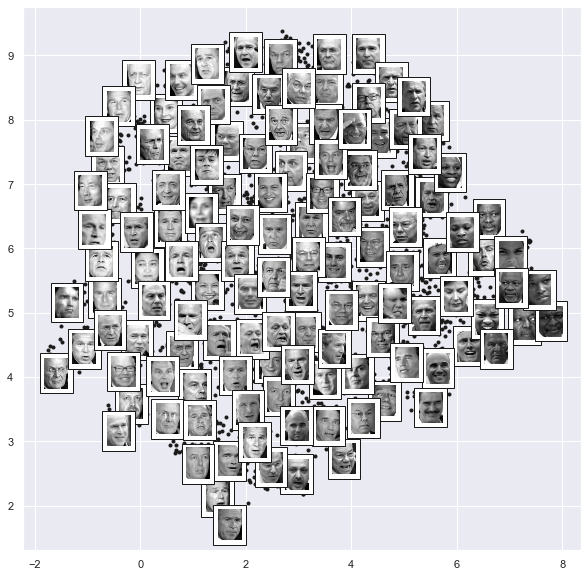

In [65]:
def plot_components(data, model, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()
    
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

fig, ax = plt.subplots(figsize=(10, 10))
model = umap.UMAP(n_neighbors=5, n_components=2)
plot_components(faces.data, model, images=faces.images[:, ::2, ::2],
                ax=ax, thumb_frac=0.05)